In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12345)

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from google.colab import files

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

In [ ]:
out_train = train["label"]
in_train = train.drop(labels = ["label"],axis = 1) 
#free memory
del train

In [ ]:
#checking for nulls in train
in_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
#checking for nulls in test
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [ ]:
#normalize the data
in_train = in_train / 255.0
test = test / 255.0

In [ ]:
#reshape image
in_train = in_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [ ]:
#convert to categorical
out_train = to_categorical(out_train, num_classes = 10)

In [ ]:
#set the random seed
random_seed = 12345

In [ ]:
#split the train and test set
in_train, in_valid, out_train, out_valid = train_test_split(in_train, out_train, test_size = 0.3, random_state=random_seed)

In [ ]:
#CNN modelling

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.05))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.05))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation = "softmax"))

In [ ]:
model.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#learning rate reduction
LR_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00001)

In [ ]:
#data augmentation to randomly modify images
data_aug = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False)

data_aug.fit(in_train)


In [ ]:
epochs = 20
batch_size = 60

In [ ]:
#fit the model
model_fit = model.fit(data_aug.flow(in_train,out_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (in_valid,out_valid),
                              verbose = 2, steps_per_epoch=in_train.shape[0] // batch_size
                              , callbacks=[LR_reduction])

Epoch 1/20
490/490 - 8s - loss: 0.0470 - accuracy: 0.9855 - val_loss: 0.0556 - val_accuracy: 0.9830 - lr: 0.0010 - 8s/epoch - 17ms/step
Epoch 2/20
490/490 - 8s - loss: 0.0408 - accuracy: 0.9873 - val_loss: 0.0650 - val_accuracy: 0.9812 - lr: 0.0010 - 8s/epoch - 17ms/step
Epoch 3/20
490/490 - 8s - loss: 0.0396 - accuracy: 0.9877 - val_loss: 0.0652 - val_accuracy: 0.9818 - lr: 0.0010 - 8s/epoch - 17ms/step
Epoch 4/20
490/490 - 9s - loss: 0.0374 - accuracy: 0.9879 - val_loss: 0.0476 - val_accuracy: 0.9859 - lr: 0.0010 - 9s/epoch - 18ms/step
Epoch 5/20
490/490 - 9s - loss: 0.0358 - accuracy: 0.9887 - val_loss: 0.0572 - val_accuracy: 0.9835 - lr: 0.0010 - 9s/epoch - 17ms/step
Epoch 6/20
490/490 - 9s - loss: 0.0302 - accuracy: 0.9905 - val_loss: 0.0388 - val_accuracy: 0.9902 - lr: 0.0010 - 9s/epoch - 17ms/step
Epoch 7/20
490/490 - 10s - loss: 0.0323 - accuracy: 0.9895 - val_loss: 0.0349 - val_accuracy: 0.9917 - lr: 0.0010 - 10s/epoch - 20ms/step
Epoch 8/20
490/490 - 8s - loss: 0.0295 - accur

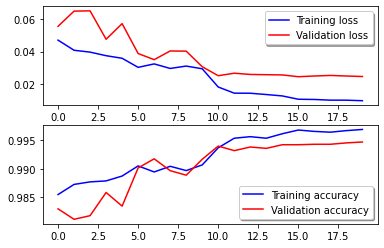

In [ ]:
#plot loss and accuracy
fig, ax = plt.subplots(2,1)
ax[0].plot(model_fit.history['loss'], color='b', label="Training loss")
ax[0].plot(model_fit.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model_fit.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(model_fit.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
#predict results
results = model.predict(test)

#select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("BD_Project_Keras_Team31_3.csv",index=False)

In [ ]:
files.download("BD_Project_Keras_Team31_3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>